# IGP 5 Models

## Preprocessing

1. import files into dataframe
2. extract 'full' days (1440 rows per date)
3. extract number of days matching scores.csv

In [1]:
# load functions in python file with magic command
%run ../code/preprocess.py

In [2]:
import pandas as pd
folderpath = '../depresjon'
output_csv_path = '../output/'
scores_csv_path = '../depresjon/scores.csv'

# extract files
df = extract_from_folder(folderpath)

# extract full days (true days)
full_df = preprocess_full_days(df)

# extract days per scores 
final = extract_days_per_scores(full_df, scores_csv_path)

# pivot df to wide format
final_pivot = pivot_dataframe(final)

In [3]:
# save to csv
final_pivot.to_csv(output_csv_path + 'preprocessed-wide.csv', index=False)
final.to_csv(output_csv_path+ 'preprocessed-long.csv', index=False)

In [4]:
# list of variable names to delete
var_list = ['df', 'full_df',  'final', 'final_pivot']

# loop over the list and delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]


### Notes

* Kept all id, date combinations to maximise data
* will split into train, test, val
* will keep proportions



## Import from CSV

1. import preprocessed csv file

In [1]:
import pandas as pd
output_csv_path = '../output/'
scores_csv_path = '../depresjon/scores.csv'

# import from csv
df = pd.read_csv(output_csv_path + 'preprocessed-long.csv', parse_dates=['timestamp', 'date'])

## Features



To calculate the features: 

* **Day / Night** - determined by hours, e.g. 08:00-20:00

$\text{{day\_night}} = \begin{cases} 
0 & \text{{if }} \text{{day\_start}} \leq \text{{hour}} < \text{{day\_end}} \\
1 & \text{{otherwise}}
\end{cases}$

* **Light / Dark** - determined by monthly sunset/sunrise times in Norway

$\text{{light\_dark}} = \begin{cases} 
0 & \text{{if }} \text{{sunrise\_time}} \leq \text{{timestamp}} < \text{{sunset\_time}} \\
1 & \text{{otherwise}}
\end{cases}$


* **Active / Inactive** - active is where the rolling average (window = 11) of 'active minute' (`activity threshold` > 5) is greater than `rolling threshold` (2)

$\text{{active\_inactive}} = \begin{cases} 
1 & \text{{if }} \text{{activity}} \geq \text{{activity\_threshold}} \\
0 & \text{{otherwise}}
\end{cases}$

$\text{{rolling\_sum}} = \text{{rolling sum of }} \text{{active\_inactive}} \text{{ over a window of }} \text{{rolling\_window}}$

$\text{{active\_inactive\_period}} = \begin{cases} 
1 & \text{{if }} \text{{rolling\_sum}} \geq \text{{rolling\_threshold}} \\
0 & \text{{otherwise}}
\end{cases}$



>all row level, therfore no data leakage - that is features are computed separately for each (id, date) combination so that there is no data leakage / contamination


* **inactiveDay**: The proportion of time during the day when the participant is inactive.

$\text{{inactiveDay}} = \frac{{\text{{Number of inactive hours during the day}}}}{{\text{{Total number of hours during the day}}}}$


* **activeNight**: The proportion of time during the night when the participant is active.

$\text{{activeNight}} = \frac{{\text{{Number of active hours during the night}}}}{{\text{{Total number of hours during the night}}}}$

* **inactiveLight**: The proportion of time during periods of light (e.g., daytime) when the participant is inactive.

$\text{{inactiveLight}} = \frac{{\text{{Number of inactive hours during periods of light}}}}{{\text{{Total number of hours during periods of light}}}}
$


* **activeDark**: The proportion of time during periods of darkness (e.g., nighttime) when the participant is active.

$\text{{activeDark}} = \frac{{\text{{Number of active hours during periods of darkness}}}}{{\text{{Total number of hours during periods of darkness}}}}$


* **mean**: The average value of activity data for each hour of the day. It represents the central tendency of the data.

$\text{{mean}}_{\text{{person-date}}} = \frac{{\sum_{i=1}^{n} \text{{activity}}_{\text{{person-date}}}(i)}}{{n}}$


* **std**: The standard deviation of activity data for each hour of the day. It measures the dispersion or spread of the data around the mean.

$\text{{std}}_{\text{{person-date}}} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\text{{activity}}_{\text{{person-date}}}(i) - \text{{mean}}_{\text{{person-date}}})^2}$


* **percentZero**: The percentage of data points that have a value of zero for each hour of the day.

$\text{{percent\_zero}}_{\text{{person-date}}} = \frac{{\text{{Number of hours with zero activity}}_{\text{{person-date}}}}}{{\text{{Total number of hours}}_{\text{{person-date}}}}} \times 100$


* **kurtosis**: A measure of the "tailedness" or shape of a distribution. It indicates how sharply peaked or flat the distribution is compared to a normal distribution. Positive kurtosis indicates a relatively peaked distribution, while negative kurtosis indicates a relatively flat distribution.

$\text{{kurtosis}}_{\text{{person-date}}} = \frac{{\frac{1}{n} \sum_{i=1}^{n} (\text{{activity}}_{\text{{person-date}}}(i) - \text{{mean}}_{\text{{person-date}}})^4}}{{\left( \frac{1}{n} \sum_{i=1}^{n} (\text{{activity}}_{\text{{person-date}}}(i) - \text{{mean}}_{\text{{person-date}}})^2 \right)^2}}$

* **median**: The middle value in the sorted list of values.

$\text{median}_{\text{person-date}} = 
\begin{cases} 
\text{activity}_{\text{person-date}}\left(\frac{n+1}{2}\right) & \text{if } n \text{ is odd} \\
\frac{1}{2} \left( \text{activity}_{\text{person-date}}\left(\frac{n}{2}\right) + \text{activity}_{\text{person-date}}\left(\frac{n}{2} + 1\right) \right) & \text{if } n \text{ is even}
\end{cases}$

* **first quartile (0.25)**: The value below which 25% of values fall.

$\text{{Q1}}_{\text{{person-date}}} = \text{{activity}}_{\text{{person-date}}}\left(\frac{n+1}{4}\right)$

* **third quartile (0.75)**: The value below which 75% of values fall.

$\text{{Q3}}_{\text{{person-date}}} = \text{{activity}}_{\text{{person-date}}}\left(\frac{3(n+1)}{4}\right)$


In [3]:
import pandas as pd
output_csv_path = '../output/'
scores_csv_path = '../depresjon/scores.csv'

# load functions in python file with magic command
%run ../code/features.py

In [4]:
# calculate features
features_full = calculate_all_features(df, sunlight_df)

In [5]:
features_full
# save to csv
features_full.to_csv(output_csv_path + 'features.csv', index=False)

## Split into Female, Male, Both datasets

In [6]:
# load functions in python file with magic command
%run ../code/model.py

# import from csv
features_full = pd.read_csv(output_csv_path + 'features.csv', parse_dates=['date'])

In [ ]:
features_full

In [7]:
male, female, both = split_and_prepare_data(features_full)

# shapes of the datasets 
print(f"Male dataset shape: {male.shape}")
print(f"Female dataset shape: {female.shape}")
print(f"Both genders dataset shape: {both.shape}")

# save to csv
male.to_csv(output_csv_path + 'male.csv', index=False)
female.to_csv(output_csv_path + 'female.csv', index=False)
both.to_csv(output_csv_path + 'both.csv', index=False)


Male dataset shape: (310, 12)
Female dataset shape: (383, 12)
Both genders dataset shape: (693, 12)


## Model


In [5]:
# load functions in python file with magic command
%run ../code/model.py


# import from csv
features_full = pd.read_csv(output_csv_path + 'features.csv', parse_dates=['date'])
male = pd.read_csv(output_csv_path + 'male.csv')
female = pd.read_csv(output_csv_path + 'female.csv')
both = pd.read_csv(output_csv_path + 'both.csv')


**Baseline Models**

* Logistic Regression
* Decision Tree
* Random Forest
* Gradient Boosting
* SVM linear
* SVM rbf
* SVC linear
* Naive Bayes
* KNN
* Neural Network
* XGBoost
* LightGBM
* AdaBooast
* QDA



![](../_images/process2-2024-04-26-200144.png)


#### Metrics

* metric selection and reason
  * `accuracy` - prop of correct predictions; good overall performanced indicator
  * `recall (sensitivity)` - prop of actual positives that are correctly identified.  ability to identify all actual cases of depression.  crucial to minimise false negatives that is failing to identify individuals who are depressed.
  * `precision` - prop of predicted depression which are correct (true positive predictions among all positive predictions) - important when need to avoid false positives (unnecessary concern, intervention, medication, treatment)
   * `F1` - harmonic mean of precision and recall - balance between the two, especially if imbalanced class distribution
   * `specificity` - ability to identify non-depression correctly - important to ensure healthy individuals are not misclassified -  measures the proportion of actual negatives that are correctly identified by the mode
  * `MCC` - takes into account true adn false positives and negatives.  reliable statistic rate that produces a high score only if the prediction obtained good results in all four matrix categories
  * `ROC-AUC - Area Under the Receiver Operating Characteristic Curve`: Evaluates the model’s ability to discriminate between the classes. A higher AUC indicates better model performance.   ROC-AUC is suitable for depression prediction when you want to evaluate the model's ability to distinguish between depressed and non-depressed individuals across different threshold settings.
  * `training time`

Considering `accuracy`, `F1`, `MCC`

### Male dataset

In [39]:
# training and validation sets
X_train, X_validation, y_train, y_validation = validation_data(male)
# save to csv
X_train.to_csv(output_csv_path + 'male_X_train.csv', index=False)
X_validation.to_csv(output_csv_path + 'male_X_validation.csv', index=False)
y_train.to_csv(output_csv_path + 'male_y_train.csv', index=False)
y_validation.to_csv(output_csv_path + 'male_y_validation.csv', index=False)

In [40]:
# read from csv
male_X_train = pd.read_csv(output_csv_path + 'male_X_train.csv')
male_y_train = pd.read_csv(output_csv_path + 'male_y_train.csv').iloc[:, 0]


In [41]:
# evaluate models
male_results = evaluate_models(models1, male_X_train, male_y_train)

# save male_results dictionary to pickle file
with open(output_csv_path + 'male_results_base.pkl', 'wb') as f:
    pickle.dump(male_results, f)


In [42]:
# open pickle file
with open(output_csv_path + 'male_results_base.pkl', 'rb') as f:
    male_results = pickle.load(f)

In [43]:
print_top_models(male_results, metric='accuracy', top_n=5)
#print_top_models(results, top_n=3)
print_top_models(male_results, metric='mcc', top_n=5)
print_top_models(male_results, metric='f1', top_n=5)
print_top_models(male_results, metric='training_time', top_n=5)

Top 5 models for accuracy:
1. QDA: 0.8931059506531206
2. XGBoost: 0.870464441219158
3. LightGBM: 0.8701015965166908
4. SVC linear: 0.859288824383164
5. Gradient Boosting: 0.8513062409288825

Top 5 models for mcc:
1. QDA: 0.8007958957751548
2. XGBoost: 0.7481466922835964
3. LightGBM: 0.7430272605945338
4. SVC linear: 0.7233327815494032
5. Gradient Boosting: 0.7074043741336317

Top 5 models for f1:
1. QDA: 0.9082051124304039
2. LightGBM: 0.8798205433208686
3. XGBoost: 0.8788753214303394
4. SVC linear: 0.8626713821424736
5. Gradient Boosting: 0.8615595575940954

Top 5 models for training time (fastest to slowest):
1. Naive Bayes: 0.01837306022644043 seconds
2. QDA: 0.019993400573730467 seconds
3. Decision Tree: 0.024086570739746092 seconds
4. SVM rbf: 0.028301715850830078 seconds
5. KNN: 0.029179477691650392 seconds



#### Model for `male` - Evaluation

`Random Forest`, `LightGBM`, `XGBoost`, `GradientBoosting` and `SVC linear` are top five models going to next round - feature evaluation.

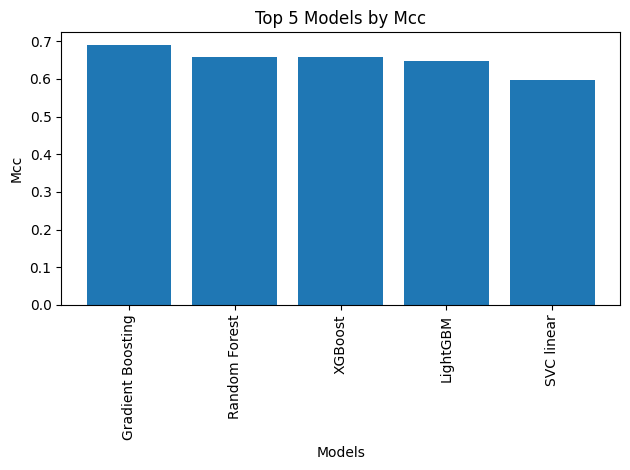

In [44]:
plot_top_models(results, metric='mcc', top_n=5)

### Female Dataset

In [45]:
# training and validation sets
X_train, X_validation, y_train, y_validation = validation_data(female)
# save to csv
X_train.to_csv(output_csv_path + 'female_X_train.csv', index=False)
X_validation.to_csv(output_csv_path + 'female_X_validation.csv', index=False)
y_train.to_csv(output_csv_path + 'female_y_train.csv', index=False)
y_validation.to_csv(output_csv_path + 'female_y_validation.csv', index=False)


In [47]:
# read from csv
female_X_train = pd.read_csv(output_csv_path + 'female_X_train.csv')
female_y_train = pd.read_csv(output_csv_path + 'female_y_train.csv').iloc[:, 0 ]


In [48]:
# evaluate models
female_results = evaluate_models(models1, female_X_train, female_y_train)

# save female_results dictionary to pickle file
with open(output_csv_path + 'female_results_base.pkl', 'wb') as f:
    pickle.dump(female_results, f)


In [49]:
# open pickle file
with open(output_csv_path + 'female_results_base.pkl', 'rb') as f:
    female_results = pickle.load(f)

In [50]:
print_top_models(female_results, metric='accuracy', top_n=5)
#print_top_models(results, top_n=3)
print_top_models(female_results, metric='mcc', top_n=5)
print_top_models(female_results, metric='f1', top_n=5)
print_top_models(female_results, metric='training_time', top_n=5)

Top 5 models for accuracy:
1. Gradient Boosting: 0.8615384615384615
2. XGBoost: 0.8492307692307692
3. Random Forest: 0.8461538461538461
4. LightGBM: 0.8430769230769231
5. SVC linear: 0.8246153846153847

Top 5 models for mcc:
1. Gradient Boosting: 0.6892419168734666
2. Random Forest: 0.6591006072445007
3. XGBoost: 0.6587325419588995
4. LightGBM: 0.6481671625513965
5. SVC linear: 0.6044617955161234

Top 5 models for f1:
1. Gradient Boosting: 0.7881821701333896
2. XGBoost: 0.7656319290465632
3. LightGBM: 0.7646511627906977
4. Random Forest: 0.7626896912611197
5. SVC linear: 0.7286772035552523

Top 5 models for training time (fastest to slowest):
1. Naive Bayes: 0.019220638275146484 seconds
2. QDA: 0.01968355178833008 seconds
3. SVC linear: 0.027652931213378907 seconds
4. KNN: 0.0323976993560791 seconds
5. Decision Tree: 0.03334488868713379 seconds



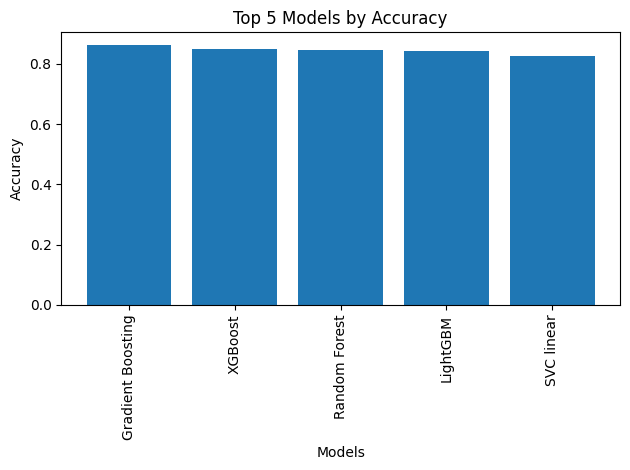

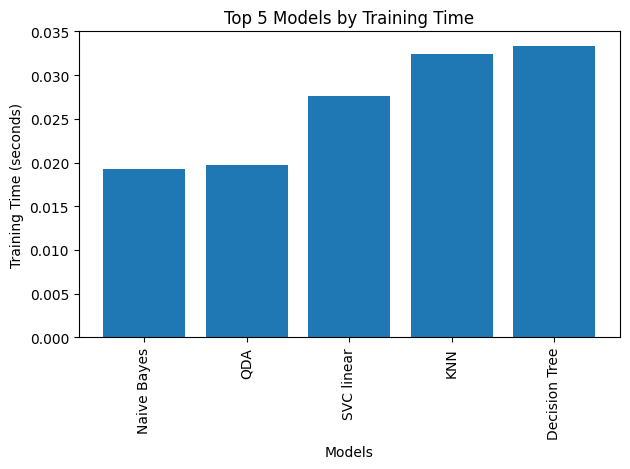

In [51]:
plot_top_models(female_results, metric='accuracy', top_n=5)
plot_top_models(female_results, metric='training_time', top_n=5)

#### Model for `female` - Evaluation

`Random Forest`, `LightGBM`, `XGBoost`, `GradientBoosting` and `SVC linear` are top five models going to next round.

### Both Dataset

In [52]:
# training and validation sets
X_train, X_validation, y_train, y_validation = validation_data(both)
# save to csv
X_train.to_csv(output_csv_path + 'both_X_train.csv', index=False)
X_validation.to_csv(output_csv_path + 'both_X_validation.csv', index=False)
y_train.to_csv(output_csv_path + 'both_y_train.csv', index=False)
y_validation.to_csv(output_csv_path + 'both_y_validation.csv', index=False)

In [53]:
# read from csv
both_X_train = pd.read_csv(output_csv_path + 'both_X_train.csv')
both_y_train = pd.read_csv(output_csv_path + 'both_y_train.csv').iloc[:, 0]

# evaluate models
both_results = evaluate_models(models1, both_X_train, both_y_train)

# save both_results dictionary to pickle file
with open(output_csv_path + 'both_results_base.pkl', 'wb') as f:
    pickle.dump(both_results, f)

In [54]:
# open pickle file
with open(output_csv_path + 'both_results_base.pkl', 'rb') as f:
    both_results = pickle.load(f)

In [55]:
print_top_models(both_results, metric='accuracy', top_n=5)
#print_top_models(results, top_n=3)
print_top_models(both_results, metric='mcc', top_n=5)
print_top_models(both_results, metric='f1', top_n=5)
print_top_models(both_results, metric='training_time', top_n=5)

Top 5 models for accuracy:
1. LightGBM: 0.8794726930320149
2. Gradient Boosting: 0.8743879472693031
3. XGBoost: 0.8743734608141388
4. AdaBoost: 0.8608286252354048
5. Random Forest: 0.8556714471968709

Top 5 models for mcc:
1. LightGBM: 0.7526492396967461
2. XGBoost: 0.7435034299792754
3. Gradient Boosting: 0.7431714155727721
4. AdaBoost: 0.719468311141312
5. Random Forest: 0.7089513642475694

Top 5 models for f1:
1. LightGBM: 0.85027129282787
2. XGBoost: 0.8464070900311895
3. Gradient Boosting: 0.8422523999154068
4. QDA: 0.8229789501951739
5. Random Forest: 0.82262090787392

Top 5 models for training time (fastest to slowest):
1. Naive Bayes: 0.018353033065795898 seconds
2. QDA: 0.018743181228637697 seconds
3. Decision Tree: 0.03690361976623535 seconds
4. KNN: 0.0375917911529541 seconds
5. SVC linear: 0.039561891555786134 seconds



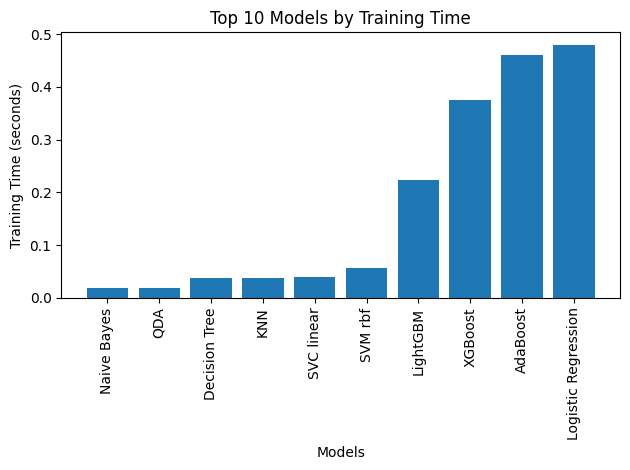

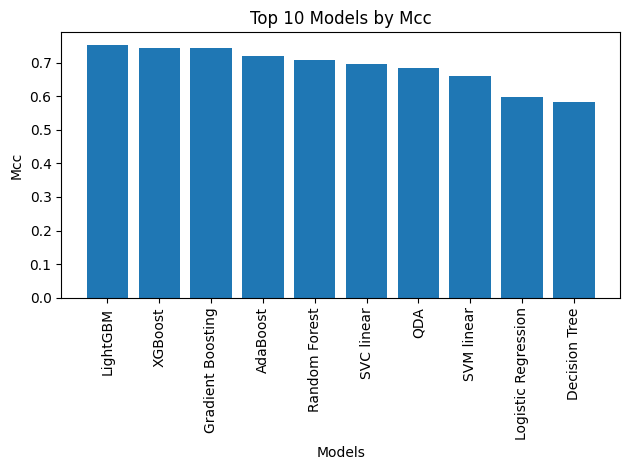

In [56]:
# plot metrics
plot_top_models(both_results, metric='training_time', top_n=10)
plot_top_models(both_results, metric='mcc', top_n=10)



#### Model for `both` - Evaluation

`Random Forest`, `LightGBM`, `XGBoost`, `GradientBoosting` and `AdaBoost` are top five models going to next round.